## Import Libraries

In [47]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image


<a name='2-2'></a>
### 2.2 - Filtering with a Threshold on Class Scores

You're going to first apply a filter by thresholding, meaning you'll get rid of any box for which the class "score" is less than a chosen threshold. 

The model gives you a total of 19x19x5x85 numbers, with each box described by 85 numbers. It's convenient to rearrange the (19,19,5,85) (or (19,19,425)) dimensional tensor into the following variables:  
- `box_confidence`: tensor of shape $(19, 19, 5, 1)$ containing $p_c$ (confidence probability that there's some object) for each of the 5 boxes predicted in each of the 19x19 cells.
- `boxes`: tensor of shape $(19, 19, 5, 4)$ containing the midpoint and dimensions $(b_x, b_y, b_h, b_w)$ for each of the 5 boxes in each cell.
- `box_class_probs`: tensor of shape $(19, 19, 5, 80)$ containing the "class probabilities" $(c_1, c_2, ... c_{80})$ for each of the 80 classes for each of the 5 boxes per cell.


In [13]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    ### START CODE HERE
    # Step 1: Compute box scores
    ##(≈ 1 line)
    box_scores = box_confidence * box_class_probs


    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ##(≈ 2 lines)
    # IMPORTANT: set axis to -1
    box_classes = tf.math.argmax(box_scores, axis = -1)
    box_class_scores = tf.math.reduce_max(box_scores, axis = -1)
    
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ## (≈ 1 line)
    filtering_mask = box_class_scores > threshold
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ## (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    ### END CODE HERE
    
    return scores, boxes, classes

<a name='2-3'></a>
### 2.3 - Non-max Suppression

Even after filtering by thresholding over the class scores, you still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

<img src="nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> <b>Figure 7</b> </u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probability) of the 3 boxes. <br> </center></caption>


In [14]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    ### START CODE HERE
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ##(≈ 7 lines)
    
    xi1 = max(box1_x1, box2_x1)
    yi1 = max(box1_y1, box2_y1)
    xi2 = min(box1_x2, box2_x2)
    yi2 = min(box1_y2, box2_y2)
    
    inter_width = max(xi2 - xi1, 0)
    inter_height = max(yi2 - yi1, 0)
    inter_area = inter_width * inter_height
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ## (≈ 3 lines)
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1) 
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    ### END CODE HERE
    
    return iou

<a name='2-4'></a>
### 2.4 - YOLO Non-max Suppression

You are now ready to implement non-max suppression. The key steps are: 
1. Select the box that has the highest score.
2. Compute the overlap of this box with all other boxes, and remove boxes that overlap significantly (iou >= `iou_threshold`).
3. Go back to step 1 and iterate until there are no more boxes with a lower score than the currently selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.


In [15]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None, ), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()

    ### START CODE HERE
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ##(≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    ##(≈ 3 lines)
    scores = tf.gather(scores, nms_indices)
    boxes = tf.gather(boxes, nms_indices)
    classes = tf.gather(classes, nms_indices)
    ### END CODE HERE

    
    return scores, boxes, classes

<a name='ex-4'></a>
### Exercise 4 - yolo_eval

Implement `yolo_eval()` which takes the output of the YOLO encoding and filters the boxes using score threshold and NMS. There's just one last implementational detail you have to know. There're a few ways of representing boxes, such as via their corners or via their midpoint and height/width. YOLO converts between a few such formats at different times, using the following functions (which are provided): 


In [16]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [17]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
                    
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs[0], yolo_outputs[1], yolo_outputs[2], yolo_outputs[3]

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # Use one of the functions you've implemented to perform Score-filtering wit h a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

<a name='3'></a>
## 3 - Test YOLO Pre-trained Model on Images

In this section, you are going to use a pre-trained model and test it on the car detection dataset.  

In [18]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

<a name='3-2'></a>
### 3.2 - Loading a Pre-trained Model


In [19]:
yolo_model = load_model("model_data/", compile=False)

<a name='3-3'></a>
### 3.3 - Run the YOLO on an Image



In [21]:

def draw_bboxes(image, boxes, box_classes, class_names, scores=None):
    """Draw bounding boxes on image.

    Draw bounding boxes with class name and optional box score on image.

    Args:
        image: An `array` of shape (width, height, 3) with values in [0, 1].
        boxes: An `array` of shape (num_boxes, 4) containing box corners as
            (y_min, x_min, y_max, x_max).
        box_classes: A `list` of indicies into `class_names`.
        class_names: A `list` of `string` class names.
        `scores`: A `list` of scores for each box.

    Returns:
        A copy of `image` modified with given bounding boxes.
    """
    #image = Image.fromarray(np.floor(image * 255 + 0.5).astype('uint8'))

    font = ImageFont.truetype(
        font='font/FiraMono-Medium.otf',
        size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    colors = get_colors_for_classes(len(class_names))

    for i, c in list(enumerate(box_classes)):
        box_class = class_names[c]
        box = boxes[i]
        draw = ImageDraw.Draw(image)

                
        if isinstance(scores.numpy(), np.ndarray):
            score = scores.numpy()[i]
            label = '{} {:.2f}'.format(box_class, score)
        else:
            label = '{}'.format(box_class)

        print("==================")
        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))
        print("==================")

        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
          
        text = box_class
          
        # drawing text size 
        draw.text((left, top), text, font = font, align ="left")  
        
        del draw

In [22]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)

    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)
    
    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_bboxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Found 2 boxes for images/giraffe.jpg
giraffe 0.89 (166, 0) (439, 448)
zebra 0.83 (241, 208) (422, 442)


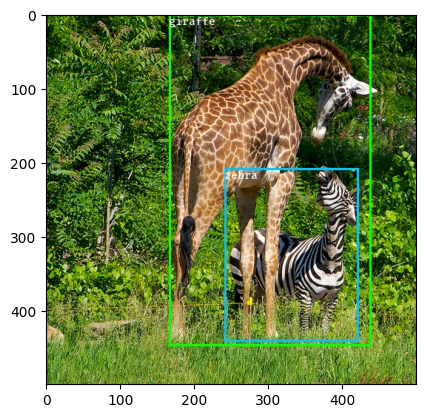

In [23]:
out_scores, out_boxes, out_classes = predict("giraffe.jpg")

<a name='4'></a>
## 4 - Export Model


In [ ]:
export_path = './tf_saved_models/1'
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors
# And stored with the default serving key
tf.saved_model.save(yolo_model, export_path)


In [ ]:
! tree --du -h .

<a name='5'></a>
## 5 - Import libraries


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm


In [64]:

def peprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    print(image.size)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    print(image_data.size)
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data



#(640, 480)
#1108992


In [65]:
import cv2
import imghdr


image, image_data = peprocess_image("images/test.jpg" , model_image_size = (608, 608))

image2 = cv2.imread("images/test.jpg")

#imageconv = Image.fromarray(image2)
imageconv = Image.fromarray(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))

print(imageconv)
print(image)

imageconv.show()



(1280, 720)
1108992
<PIL.Image.Image image mode=RGB size=1280x720 at 0x7F57F505CFD0>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7F58A3D39F70>


<a name='6'></a>

## 6 - Predictions with TensorflowServing


In [27]:
image, image_data = preprocess_image("images/test.jpg" , model_image_size = (608, 608))

print(image_data.shape)
plt.show(image)
    

(1, 608, 608, 3)


In [28]:
print(type(image_data))
data = json.dumps({"signature_name": "serving_default", 
                   "instances": image_data.tolist()})

HEADERS = {'content-type': 'application/json'}
MODEL1_API_URL = 'http://localhost:8605/v1/models/yolo_model:predict'

json_response = requests.post(MODEL1_API_URL, data=data, headers=HEADERS)
predictions = json.loads(json_response.text)['predictions']

print(type(predictions))


<class 'numpy.ndarray'>
<class 'list'>


tf.Tensor(
[0.8925936  0.79853904 0.74766463 0.69886523 0.6764997  0.67009383
 0.60454655 0.45153055 0.38010797 0.35196784], shape=(10,), dtype=float32) tf.Tensor(
[[ 299.20648   366.4665    647.9253    745.0416  ]
 [ 281.84085   761.61285   411.61606   942.4185  ]
 [ 302.6947    158.6954    440.04492   346.30508 ]
 [ 323.73416   947.06714   704.46906  1288.1985  ]
 [ 279.18182   705.43933   350.57584   785.76465 ]
 [ 266.52957     4.774132  407.04578   220.39105 ]
 [ 285.22232   925.07153   373.9583   1045.1543  ]
 [ 296.14294   335.8456    334.99976   377.2418  ]
 [ 273.1682    965.0892    292.3916   1022.8228  ]
 [ 194.85675   680.5963    214.72716   692.4175  ]], shape=(10, 4), dtype=float32) tf.Tensor([2 2 2 2 2 5 2 2 2 9], shape=(10,), dtype=int64)
car 0.89 (366, 299) (745, 648)
car 0.80 (762, 282) (942, 412)
car 0.75 (159, 303) (346, 440)
car 0.70 (947, 324) (1280, 704)
car 0.68 (705, 279) (786, 351)
bus 0.67 (5, 267) (220, 407)
car 0.60 (925, 285) (1045, 374)
car 0.45 (336, 296

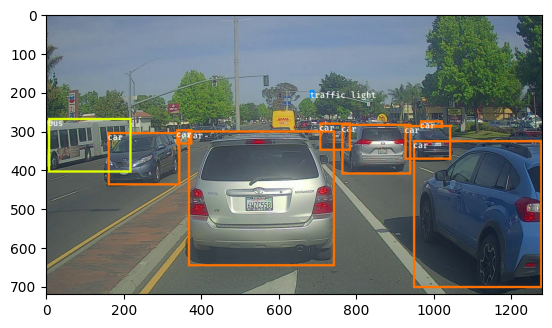

In [29]:
tensor = tf.convert_to_tensor(predictions)

yolo_outputs = yolo_head(tensor, anchors, len(class_names))
out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

print(out_scores, out_boxes, out_classes)

    
colors = get_colors_for_classes(len(class_names))
draw_bboxes(image, out_boxes, out_classes, class_names, out_scores)

print("+=============")
print(type(image))
# Save the predicted bounding box on the image
#image.save(os.path.join("out", image_file), quality=100)
# Display the results in the notebook
#output_image = Image.open(os.path.join("out", image_file))
#imshow(output_image)

#Print predictions info
#print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
#Generate colors for drawing bounding boxes.
#colors = get_colors_for_classes(len(class_names))
# Draw bounding boxes on the image file
#draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
#draw_bboxes(image, out_boxes, out_classes, class_names, out_scores)
# Save the predicted bounding box on the image
#image.save(os.path.join("out", image_file), quality=100)
# Display the results in the notebook
#output_image = Image.open(os.path.join("out", image_file))

imshow(image)

#return out_scores, out_boxes, out_classes

In [30]:
def pred(tensor):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    yolo_outputs = yolo_head(tensor, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)
    
    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_bboxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    
    imshow(output_image)

    return out_scores, out_boxes, out_classes

In [79]:
ret = []
label =0
left = 1
top = 2
right = 3
bottom = 4

ret.append((label,left, top, right, bottom))
ret.append((label,left, top, right, bottom))
ret.append((label,left, top, right, bottom))


In [80]:
print(ret)

[(0, 1, 2, 3, 4), (0, 1, 2, 3, 4), (0, 1, 2, 3, 4)]


In [83]:
print(ret[0]) 

(0, 1, 2, 3, 4)


In [84]:

print(len(ret))

3


In [85]:
for r in ret:
    cv2

(0, 1, 2, 3, 4)
(0, 1, 2, 3, 4)
(0, 1, 2, 3, 4)



(eog:28761): GLib-WARNING **: 12:02:32.700: GError set over the top of a previous GError or uninitialized memory.
This indicates a bug in someone's code. You must ensure an error is NULL before it's set.
The overwriting error message was: Error in getting image file info

(eog:28761): GLib-WARNING **: 12:02:32.718: GError set over the top of a previous GError or uninitialized memory.
This indicates a bug in someone's code. You must ensure an error is NULL before it's set.
The overwriting error message was: Error in getting image file info

(eog:28761): GLib-WARNING **: 12:02:32.721: GError set over the top of a previous GError or uninitialized memory.
This indicates a bug in someone's code. You must ensure an error is NULL before it's set.
The overwriting error message was: Error in getting image file info

(eog:28761): GLib-WARNING **: 12:02:32.723: GError set over the top of a previous GError or uninitialized memory.
This indicates a bug in someone's code. You must ensure an error i